# Proyecto 03 - Series de Tiempo - Emanuel Caneva


## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset - Análisis exploratorio de Datos

#### 1.1 Análisis de los datasets por años

Importamos las librerías necesarias

In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Data types
import datetime

# statistics
from statsmodels.graphics.tsaplots import plot_acf

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

#Ensemble models
from sklearn.ensemble import RandomForestRegressor

#Error metrics

from sklearn.metrics import mean_squared_error

#HyperParameter optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid

Cargamos el dataset y exploramos

In [2]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

De cada dataset analizamos las primeras y últimas filas, la cantidad de pasos por días y por hora fin para determinar cual es la hora pico, forma de pago, sentido etc. La idea es ver si en todos los años se repite el mismo comportamiento y luego compararlo con el dataset filtrado que vamos a usar para predecir.

##### Información dataset año 2019

In [3]:
data_2019.info()
data_2019.head().append(data_2019.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16
812148,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,NO COBRADO,7
812149,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,TELEPASE,4
812150,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Pesado,NO COBRADO,1
812151,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,NO COBRADO,7
812152,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,TELEPASE,7


In [4]:
data_2019.shape

(812153, 10)

Estadistica cantidad de pasos 2019

In [5]:
data_2019.cantidad_pasos.describe().round(2)

count    812153.00
mean        156.02
std         387.35
min           1.00
25%           4.00
50%          15.00
75%          72.00
max        6677.00
Name: cantidad_pasos, dtype: float64

Cantidad de pasos por día Año 2019

In [6]:
data_2019.groupby(['dia']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

dia
Jueves       19643343
Viernes      19642569
Martes       18967607
Miércoles    18907977
Lunes        18004476
Sábado       16641060
Domingo      14903493
Name: cantidad_pasos, dtype: int64

Cantidad de pasos por hora año 2019

In [7]:
data_2019.groupby(['hora_fin']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

hora_fin
18    8160068
19    8086367
17    7795827
13    7760803
14    7750183
16    7539166
15    7433877
12    7423961
9     7406053
10    7255964
11    7129193
20    6905415
8     6590060
21    6056895
22    4714698
7     4272851
23    3373187
0     2509773
6     2079528
1     2067541
2     1495294
3     1058568
5     1014427
4      830826
Name: cantidad_pasos, dtype: int64

Cantidad de pasos por forma de pago

In [8]:
data_2019.groupby(['forma_pago']).sum().sort_values (by=['cantidad_pasos'] ,ascending=False) ['cantidad_pasos']

forma_pago
TELEPASE           63570459
EFECTIVO           53621459
NO COBRADO          6267683
EXENTO              1310757
INFRACCION          1098472
T. DISCAPACIDAD      841695
Name: cantidad_pasos, dtype: int64

##### Información dataset año 2018

In [9]:
data_2018.info()
data_2018.head().append(data_2018.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115
1375903,2018,2018-12-31,21,22,Lunes,Sarmiento,Provincia,Liviano,TELEPASE,62
1375904,2018,2018-12-31,21,22,Lunes,Sarmiento,Provincia,Pesado,TELEPASE,1
1375905,2018,2018-12-31,22,23,Lunes,Sarmiento,Provincia,Liviano,NO COBRADO,3
1375906,2018,2018-12-31,22,23,Lunes,Sarmiento,Provincia,Liviano,TELEPASE,13
1375907,2018,2018-12-31,23,0,Lunes,Sarmiento,Provincia,Liviano,NO COBRADO,3


In [10]:
data_2018.shape

(1375908, 10)

Estadistica cantidad de pasos 2018

In [11]:
data_2018.cantidad_pasos.describe().round(2)

count    1375908.00
mean          89.46
std          291.09
min            1.00
25%            2.00
50%            6.00
75%           26.00
max         5722.00
Name: cantidad_pasos, dtype: float64

Cantidad de pasos por día Año 2018

In [12]:
data_2018.groupby(['dia']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

dia
Viernes      20140109
Jueves       19671493
Miércoles    19256410
Martes       18552574
Lunes        17600378
Sábado       15191200
Domingo      12681528
Name: cantidad_pasos, dtype: int64

Cantidad de pasos por hora Año 2018

In [13]:
data_2018.groupby(['hora_fin']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

hora_fin
18    7903494
19    7812306
14    7528667
17    7464083
13    7436815
16    7304379
15    7248805
9     7145617
12    7096885
10    6907335
20    6784383
11    6783101
8     6421052
21    6049291
22    4762690
7     4246664
23    3393698
0     2444506
6     2055342
1     2007835
2     1464310
3     1036406
5      979158
4      816870
Name: cantidad_pasos, dtype: int64

Cantidad de pasos por forma de pago

In [14]:
data_2018.groupby(['forma_pago']).sum().sort_values (by=['cantidad_pasos'] ,ascending=False) ['cantidad_pasos']

forma_pago
EFECTIVO                60225521
TELEPASE                53762821
NO COBRADO               6072877
EXENTO                   1250539
TARJETA DISCAPACIDAD     1061614
INFRACCION                720320
Name: cantidad_pasos, dtype: int64

##### Información dataset año 2017

In [15]:
data_2017.info()
data_2017.head().append(data_2017.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94
1372640,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,3
1372641,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,TELEPASE,10
1372642,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1
1372643,2017,2017-12-31,23,0,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,1
1372644,2017,2017-12-31,23,0,Domingo,Sarmiento,Provincia,Liviano,TELEPASE,4


In [16]:
data_2017.shape

(1372645, 10)

Estadistica cantidad de pasos 2017

In [17]:
data_2017.cantidad_pasos.describe().round(2)

count    1372645.00
mean          90.94
std          301.64
min            1.00
25%            2.00
50%            7.00
75%           28.00
max         4271.00
Name: cantidad_pasos, dtype: float64

Cantidad de pasos por día Año 2017

In [18]:
data_2017.groupby(['dia']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

dia
Viernes      20287896
Miércoles    19656535
Jueves       19617942
Martes       18718671
Lunes        17870939
Sábado       15687709
Domingo      12993798
Name: cantidad_pasos, dtype: int64

Cantidad de pasos por hora Año 2017

In [19]:
data_2017.groupby(['hora_fin']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

hora_fin
18    8085620
19    8020327
17    7669496
14    7618985
13    7518666
16    7443988
15    7354553
9     7256399
12    7181753
10    6977117
20    6925878
11    6865667
8     6540007
21    6191608
22    4857434
7     4115584
23    3417049
0     2444610
6     2024687
1     2012805
2     1494631
3     1035795
5      974348
4      806483
Name: cantidad_pasos, dtype: int64

Cantidad de pasos por tipo de pago

In [20]:
data_2017.groupby(['forma_pago']).sum().sort_values (by=['cantidad_pasos'] ,ascending=False) ['cantidad_pasos']

forma_pago
EFECTIVO                69502938
TELEPASE                46612698
NO COBRADO               4845670
EXENTO                   1677497
TARJETA DISCAPACIDAD     1565099
INFRACCION                629550
Otros                         22
MONEDERO                      16
Name: cantidad_pasos, dtype: int64

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [21]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [22]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [23]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [24]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

**Conclusiones del análisis de los dataset por separado:**

Podemos decir que entre los tres dataset no hay demasiadas diferencias en el comportamiento en cuanto a dias y horas picos,  siendo Viernes y jueves los días mas transitados y Domingo el día con menos tráfico, la hora pico para todos los años es entre las 17 y las 18.
En cuanto a la forma de pago el metodo Telepase va creciendo hasta convertirse en el principal metodo de pago en el año 2019 por sobre el efectivo, es mas justamente en estos días el Telepase se implementó como obligatorio en algunas autopistas.

#### 1.2 Análisis del dataset unificado y filtrado



Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [25]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

In [26]:
dataset.shape

(238869, 10)

In [27]:
dataset.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
80,2019,2019-01-01,1,2,Martes,Illia,Centro,Liviano,EFECTIVO,537
86,2019,2019-01-01,1,2,Martes,Illia,Centro,Pesado,EFECTIVO,1
88,2019,2019-01-01,1,2,Martes,Illia,Provincia,Liviano,EFECTIVO,443
94,2019,2019-01-01,1,2,Martes,Illia,Provincia,Pesado,EFECTIVO,1
149,2019,2019-01-01,2,3,Martes,Illia,Centro,Liviano,EFECTIVO,769


In [28]:
#Descripcion de la variable cantidad de pasos
dataset.cantidad_pasos.describe().round(2)

count    238869.00
mean        200.38
std         403.25
min           1.00
25%           2.00
50%          11.00
75%         104.00
max        2416.00
Name: cantidad_pasos, dtype: float64

Analizamos la cantidad de pasos por dias

In [29]:
dataset.groupby(['dia']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

dia
Viernes      7647272
Jueves       7302169
Miércoles    7125526
Martes       6865551
Lunes        6691387
Sábado       6441715
Domingo      5791961
Name: cantidad_pasos, dtype: int64

Analizamos la cantidad de pasos por hora, tomando como referencia la variable hora_fin

In [30]:
dataset.groupby(['hora_fin']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

hora_fin
18    3115036
19    3071455
14    3005578
17    2993721
16    2969568
15    2933388
13    2907990
12    2729369
20    2661885
11    2551110
9     2476701
10    2471790
21    2339949
8     2276977
22    1875810
7     1564013
23    1412685
0     1057141
1      879116
6      781617
2      614594
3      429898
5      411330
4      334860
Name: cantidad_pasos, dtype: int64

Analizamos el sentido del tráfico

In [31]:
dataset.groupby(['sentido']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

sentido
Centro       24707366
Provincia    23158215
Name: cantidad_pasos, dtype: int64

Análizamos el tráfico según los tipos de vehículos

In [32]:
dataset.groupby(['tipo_vehiculo']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

tipo_vehiculo
Liviano    46338529
Pesado      1527052
Name: cantidad_pasos, dtype: int64

Analizamos la cantidad de pasos agrupados por fecha

In [33]:
dataset.groupby(['fecha']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

fecha
2017-12-07    63127
2017-11-24    61594
2017-10-13    61421
2017-11-10    61382
2017-11-17    61259
              ...  
2019-12-01    20553
2018-11-29    19728
2019-01-13    18076
2018-12-01      350
2017-04-06       40
Name: cantidad_pasos, Length: 1091, dtype: int64

Comprobamos si hay valores faltantes

In [34]:
dataset.isnull().sum()

periodo           0
fecha             0
hora_inicio       0
hora_fin          0
dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
dtype: int64

**Conclusiones del análisis del dataset unificado:**

En este análsis intentamos ver el comportamiento del dataset unificado, para ellos nos planteamos ciertas preguntas:

* ¿Cuales son los días de mayor y menor tráfico? 
Los días de mayor tráfico son los Viernes y los de menor tráfico son los Domingos, viendo los números es como que el tráfico va creciendo de Lunes a Viernes y baja el fin de semana.


* ¿Cuál es la hora pico?
Haciendo una agrupación por la hora de fin se ve que la hora pico es la de las 18 y le sigue las 19, podemos concluir entonces que el rango horario de 17 a 19 es donde se produce la mayor afluencia de tráfico.


* ¿En que sentido hay mas tráfico?
Si bien hay mayor tráfico en sentido hacia el centro no hay mucha diferencia con la cantidad de tráfico hacia provincia.


* ¿Hay días donde donde no hay pasos? Si es así, ¿A que se debe?
Esta pregunta se plantea en este espacio porque es una curiosidad que intento descubrir con el dataset, pero se verifica luego con el análisis resampleado por día y la búsqueda de outliers. Efectivamente hay ciertos días donde no hay pasos, esto se debe a que se levantaron las barreras por distintos paro generales contra el gobierno de turno, o los días previos a la cumbre del G-20 en Buenos Aires.


#### 1.3 Preparado del dataset (agregado de columna fecha)

In [35]:
#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [36]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [37]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [38]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


In [39]:
dataset.describe()

,cantidad_pasos
count,238869.000000
mean,200.384232
std,403.246904
min,1.000000
25%,2.000000
50%,11.000000
75%,104.000000
max,2416.000000


#### 1.4 Análisis aplicando resample y autocorrelaciones

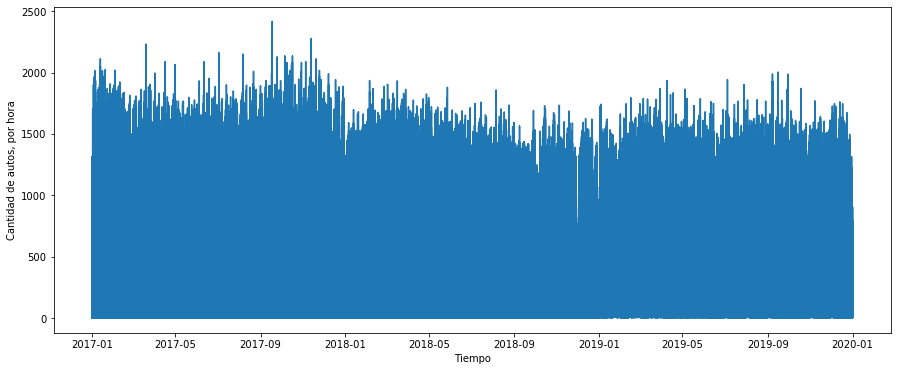

In [40]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

Resampleo por día

In [41]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [42]:
diario.describe()

,cantidad_pasos
count,1095.000000
mean,43712.859361
std,8192.736927
min,0.000000
25%,39061.500000
50%,43761.000000
75%,49498.000000
max,63127.000000


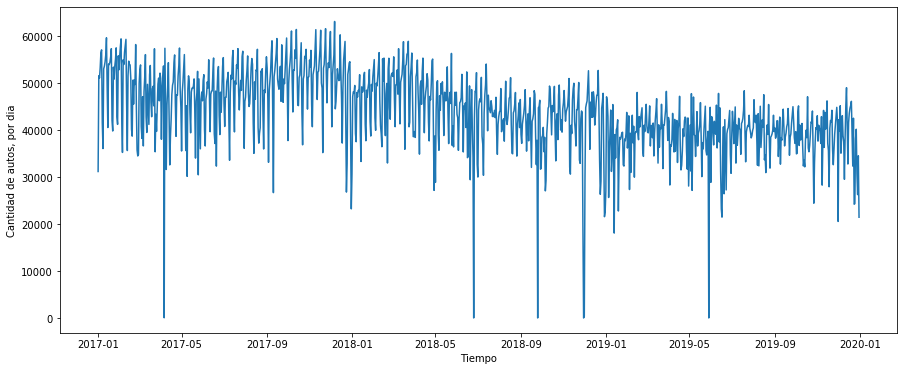

In [43]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Graficamos en una ventana de tiempo de un mes particular donde observamos que en un día no hay pasos

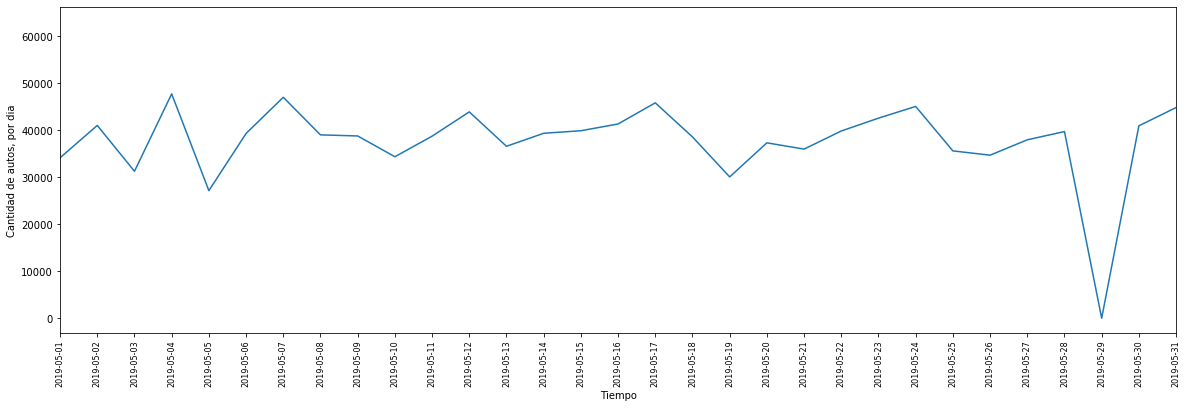

In [44]:
plt.figure(figsize = (20,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.xticks(diario.index)
plt.xticks(rotation=90,size=8)
plt.xlim(datetime.date(2019,5,1), datetime.date(2019,5,31))
plt.show()

Graficamos en una ventana de tiempo de una semana particular

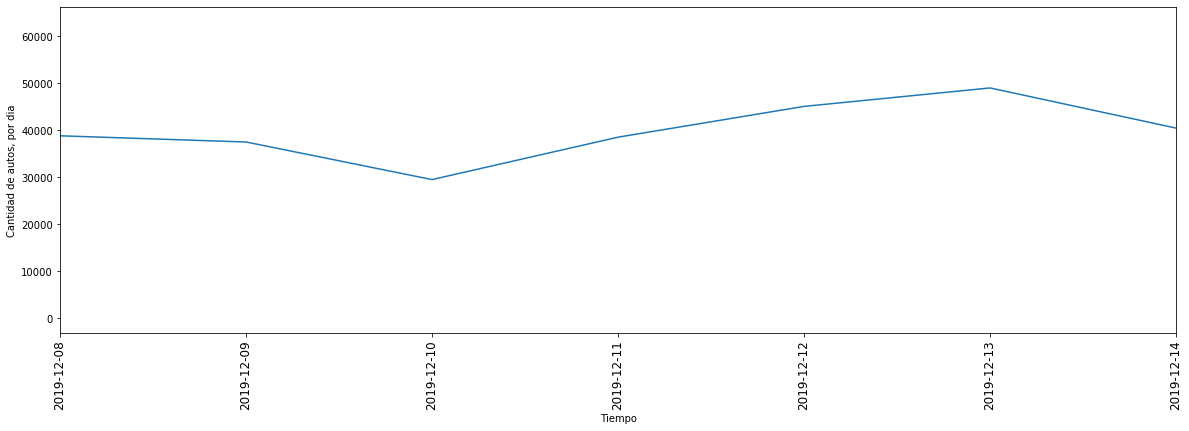

In [45]:

plt.figure(figsize = (20,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.xticks(diario.index)
plt.xticks(rotation=90,size=12)
plt.xlim(datetime.date(2019,12,8), datetime.date(2019,12,14))
plt.show()

*Como primer análisis resampleando la serie por días se puede observar que hay un leve tendencia negativa en la serie completa, que hay días donde no hay pasos, y viendo el último gráfico se una semana particular se da el comportamiento general de una semana normal donde el Domingo hay menos tráfico y el mismo va subiendo hacia el Vienres para luego decaer el sábado.*

Resampleo por Semana

In [46]:
semanal = dataset.resample('W', on = 'fecha').sum()
print(semanal.shape)
semanal.head()

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581


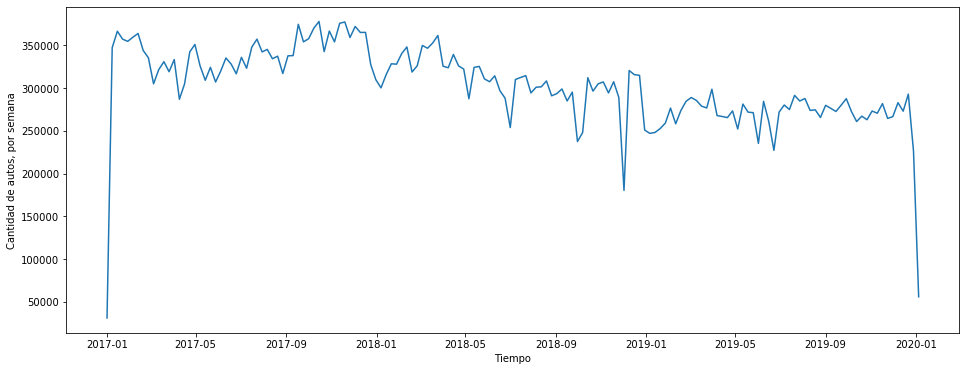

In [47]:
plt.figure(figsize = (16,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

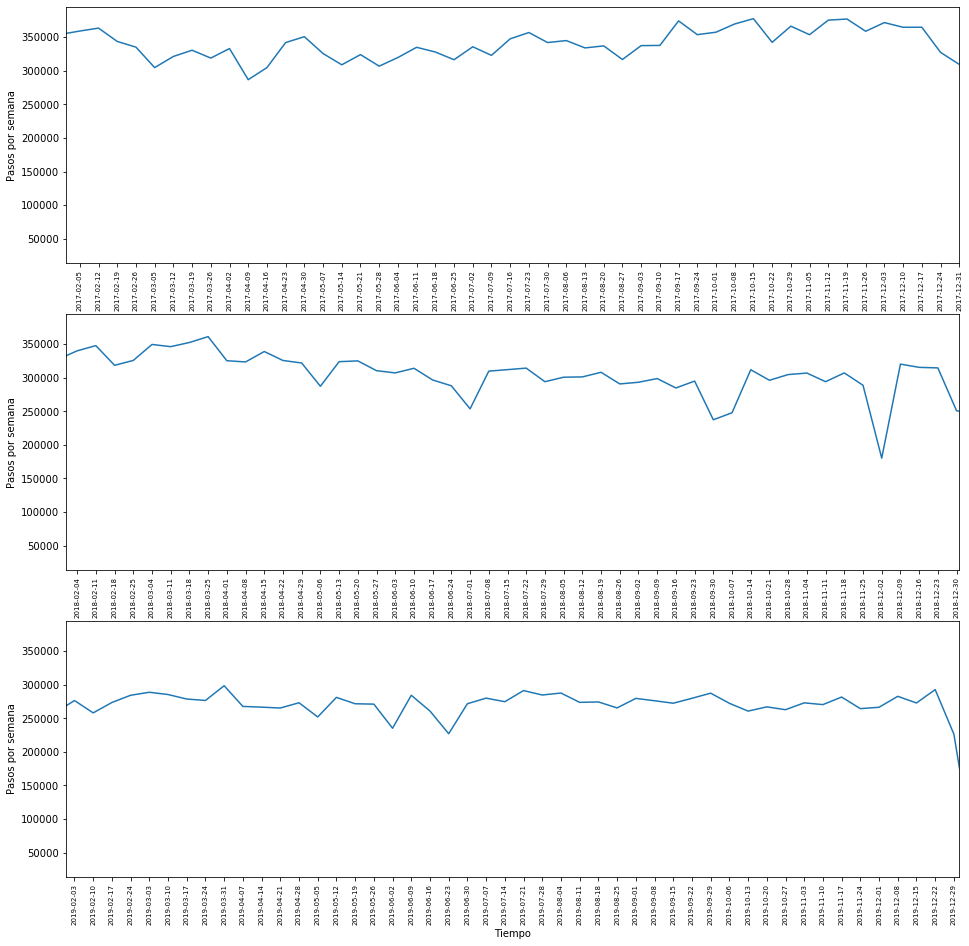

In [48]:
#Graficamos la serie semanal comparando los tres años
plt.figure(figsize = (16,16))

plt.subplot(3,1,1)
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xticks(semanal.index)
plt.xticks(rotation=90,size=7)
plt.xlabel('Tiempo')
plt.ylabel('Pasos por semana')
plt.xlim(datetime.date(2017,1,31), datetime.date(2017,12,31))

plt.subplot(3,1,2)
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xticks(semanal.index)
plt.xticks(rotation=90,size=7)
plt.xlabel('Tiempo')
plt.ylabel('Pasos por semana')
plt.xlim(datetime.date(2018,1,31), datetime.date(2018,12,31))

plt.subplot(3,1,3)
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xticks(semanal.index)
plt.xticks(rotation=90,size=7)
plt.xlabel('Tiempo')
plt.ylabel('Pasos por semana')
plt.xlim(datetime.date(2019,1,31), datetime.date(2019,12,31))

plt.show()

*Analizando la serie resampleada por semana se ve obviamente una tendencia levemente negativa en el total de la serie pero comparando la misma entre los 3 años es muy dificil analizar por la cantidad de datos.*

Resampleo por Mes

In [49]:
mensual = dataset.resample('M', on = 'fecha').sum()
print(mensual.shape)
mensual.head()

(36, 1)


,cantidad_pasos
fecha,
2017-01-31,1565260
2017-02-28,1363113
2017-03-31,1451214
2017-04-30,1373985
2017-05-31,1407136


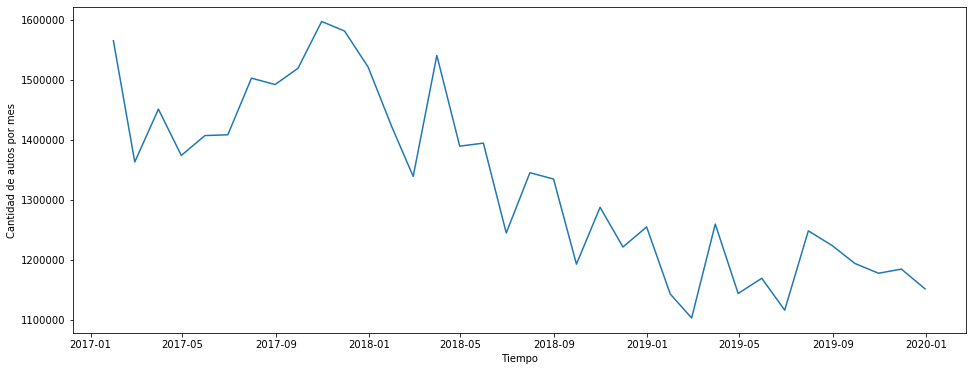

In [50]:
plt.figure(figsize = (16,6))
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos por mes')
plt.show()

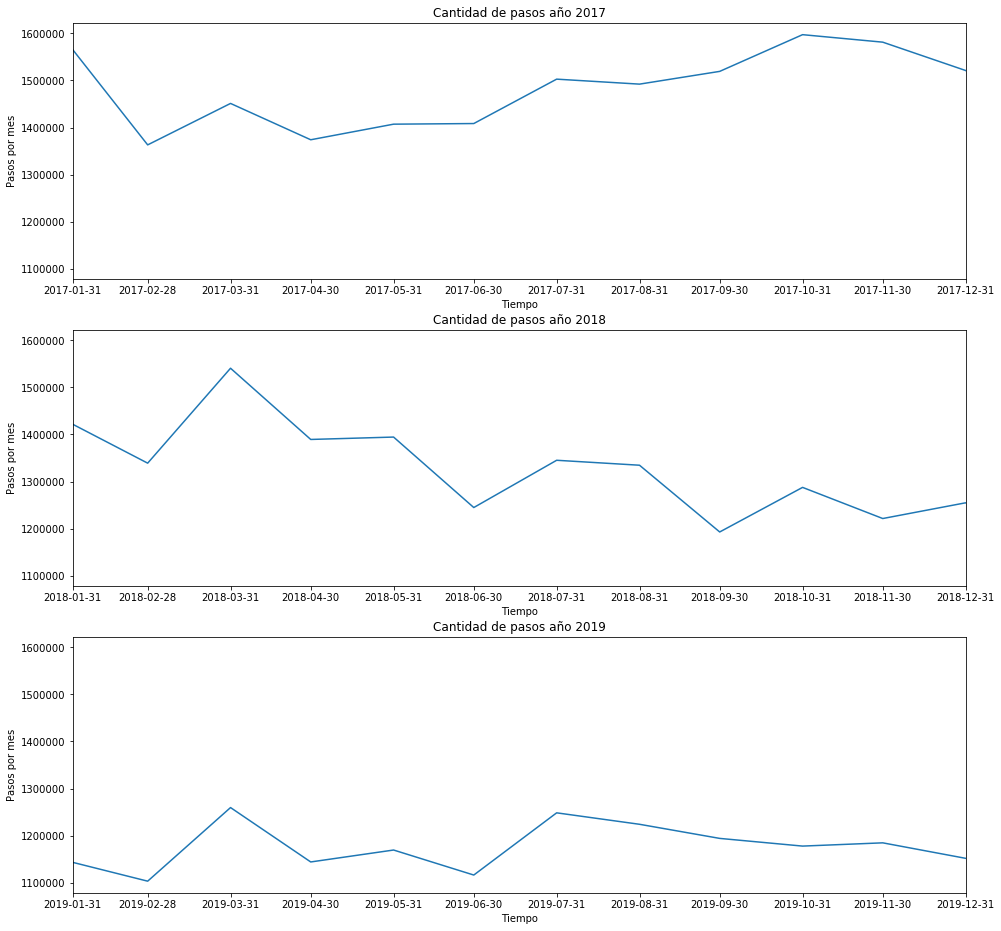

In [51]:
#Graficamos la serie mensual comparando los tres años
plt.figure(figsize = (16,16))

plt.subplot(3,1,1)
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xticks(mensual.index)
plt.title('Cantidad de pasos año 2017')
plt.xlabel('Tiempo')
plt.ylabel('Pasos por mes')
plt.xlim(datetime.date(2017,1,31), datetime.date(2017,12,31))

plt.subplot(3,1,2)
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xticks(mensual.index)
plt.title('Cantidad de pasos año 2018')
plt.xlabel('Tiempo')
plt.ylabel('Pasos por mes')
plt.xlim(datetime.date(2018,1,31), datetime.date(2018,12,31))

plt.subplot(3,1,3)
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xticks(mensual.index)
plt.title('Cantidad de pasos año 2019')
plt.xlabel('Tiempo')
plt.ylabel('Pasos por mes')
plt.xlim(datetime.date(2019,1,31), datetime.date(2019,12,31))

plt.show()

In [52]:
mensual.groupby(['fecha']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

fecha
2017-10-31    1597356
2017-11-30    1581428
2017-01-31    1565260
2018-03-31    1540839
2017-12-31    1521177
2017-09-30    1519327
2017-07-31    1502820
2017-08-31    1492232
2017-03-31    1451214
2018-01-31    1421667
2017-06-30    1408464
2017-05-31    1407136
2018-05-31    1394544
2018-04-30    1389468
2017-04-30    1373985
2017-02-28    1363113
2018-07-31    1345221
2018-02-28    1339086
2018-08-31    1334697
2018-10-31    1287581
2019-03-31    1259526
2018-12-31    1254843
2019-07-31    1248324
2018-06-30    1244766
2019-08-31    1223990
2018-11-30    1221405
2019-09-30    1194001
2018-09-30    1192827
2019-11-30    1184560
2019-10-31    1177647
2019-05-31    1169278
2019-12-31    1151645
2019-04-30    1143925
2019-01-31    1143023
2019-06-30    1116120
2019-02-28    1103086
Name: cantidad_pasos, dtype: int64

*Viendo las series por mes se puede ver como el tráfico decae en Febrero, epoca de vacaciones y luego repunta para Marzo, pero a diferencia entre los 3 años en el 2017 va creciendo hacia alcanzar picos en los últimos meses del año, no así en los otros dos.*

Autocorrelación: analizamos en forma gráficas la autocorrelación de la serie según el resampleo diario, semanal y mensual

Semanal

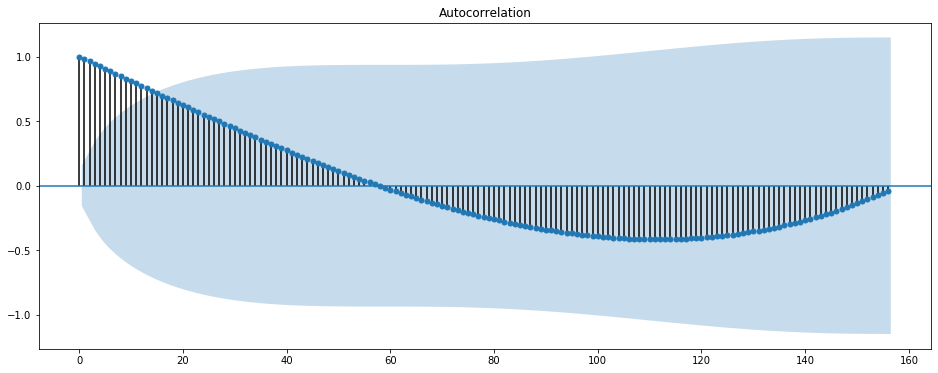

In [53]:
plt.figure(figsize = (16,6))
plot_acf(semanal.index, lags = 52*3,ax = plt.gca())
plt.show()

Mensual

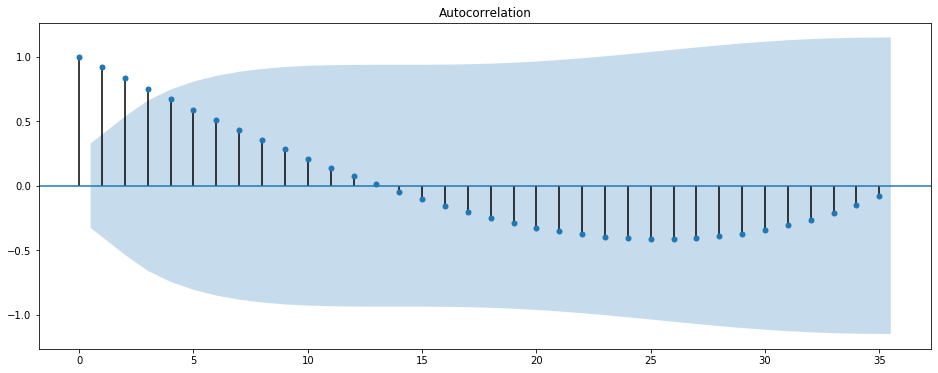

In [54]:
plt.figure(figsize = (16,6))
plot_acf(mensual.index, lags = 35, ax = plt.gca())
plt.show()

Diario

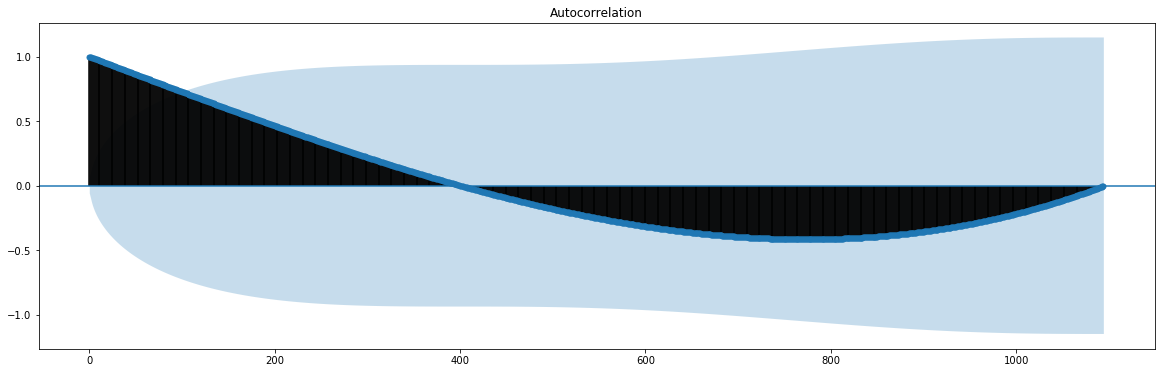

In [55]:
plt.figure(figsize = (20,6))
plot_acf(diario.index,lags=365+365+364 ,ax = plt.gca())
plt.show()

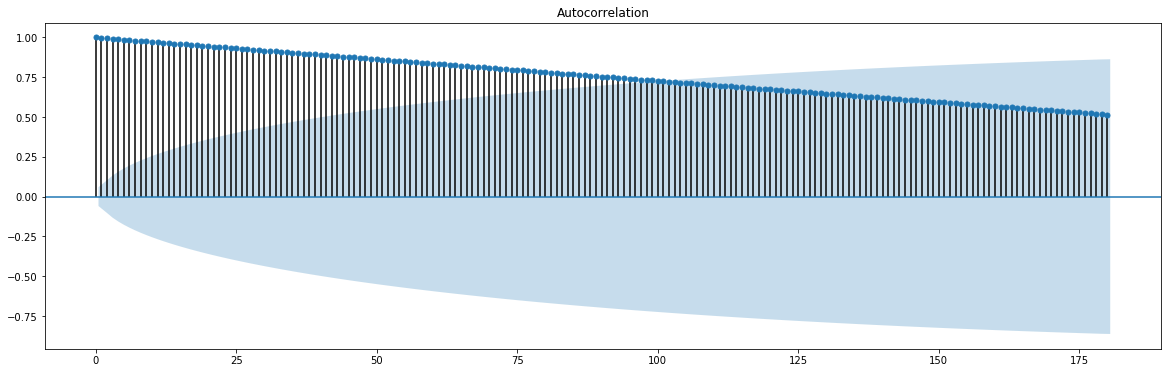

In [56]:
plt.figure(figsize = (20,6))
plot_acf(diario.index,lags=180 ,ax = plt.gca())
plt.show()

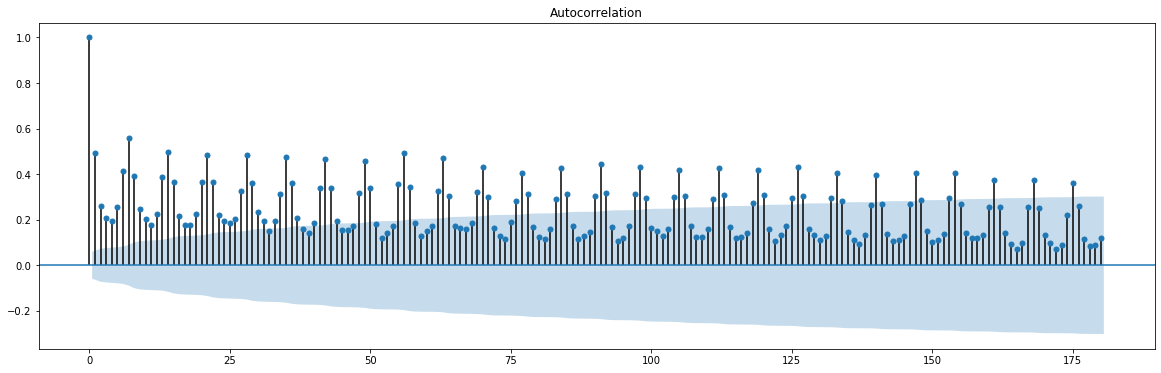

In [57]:
plt.figure(figsize = (20,6))
plot_acf(diario,lags=180 ,ax = plt.gca())
plt.show()

**Conclusiones Autocorrelación**

Como se puede ver en las gráficas, los residuos de la serie o valores que caen fuera del intervalo de confiaza y tienen una fuerte correlación estan dentro de los 120 días, 18 semanas o 4 meses, aproximadamente, luego la serie toma valores de correlación dentro del intervalo indicado, también se observa en el último gráfico que la serie va repitiendo su comportamiento cada 7 días o lags, lo que correspondería a una semana.

#### 1.5 Componentes de la serie

En este punto vamos a analizar la serie resampleada por días ya que es lo que vamos a intentar predecir, la elección es mas que nada pensando en la utilidad considero mas oportuno tener la estimación de cuantos autos van a pasar por día, por ejemplo para asignar personal a las cabinas, que no en un semana completa.

Buscamos los outliers de la serie resampleada por días

In [58]:
#Definiumos la función para eliminar outliers
def eliminar_outliers(dataset,var):
    q25,q75 = np.percentile(dataset[var], [25,75])
    iqr = q75 - q25
    minimo = q25 - 1.5*iqr
    maximo = q75 + 1.5*iqr
    mascara_outliers = np.logical_or(dataset[var] < minimo, dataset[var] > maximo)
    return mascara_outliers

In [59]:
mascara_outliers=eliminar_outliers(diario,'cantidad_pasos')
mascara_outliers.sum()

16

In [60]:
#Analizamos los outliers obtenidos
dataset_outliers=diario[mascara_outliers]
dataset_outliers

,cantidad_pasos
fecha,
2017-04-06,40
2017-12-31,23229
2018-06-25,0
2018-09-25,0
2018-11-29,19728
2018-11-30,0
2018-12-01,350
2018-12-30,21559
2018-12-31,22599


In [61]:
dataset_outliers.sort_values('cantidad_pasos')

,cantidad_pasos
fecha,
2018-06-25,0
2018-09-25,0
2018-11-30,0
2019-05-29,0
2017-04-06,40
2018-12-01,350
2019-01-13,18076
2018-11-29,19728
2019-12-01,20553


Una vez detectados y analizados los outliers vamos a rellenar los valores con nan y luego interpolar la serie

In [62]:
diario.cantidad_pasos[mascara_outliers]=np.nan
print(diario.isna().sum())
diario = diario.interpolate(method='time')
print(diario.isna().sum())

cantidad_pasos    16
dtype: int64
cantidad_pasos    0
dtype: int64


Obtenemos los componentes de la serie usando statsmodels

In [63]:
result = seasonal_decompose(diario.cantidad_pasos, model='additive')

In [64]:
print(result.trend)

fecha
2017-01-01             NaN
2017-01-02             NaN
2017-01-03             NaN
2017-01-04    48904.285714
2017-01-05    49601.714286
                  ...     
2019-12-27    31197.428571
2019-12-28    32669.285714
2019-12-29             NaN
2019-12-30             NaN
2019-12-31             NaN
Freq: D, Name: trend, Length: 1095, dtype: float64


In [65]:
print(result.seasonal)

fecha
2017-01-01   -6646.321063
2017-01-02   -1110.020909
2017-01-03      11.358507
2017-01-04    1833.212327
2017-01-05    3199.069241
                 ...     
2019-12-27    5175.715074
2019-12-28   -2463.013177
2019-12-29   -6646.321063
2019-12-30   -1110.020909
2019-12-31      11.358507
Freq: D, Name: seasonal, Length: 1095, dtype: float64


In [66]:
print(result.resid)

fecha
2017-01-01            NaN
2017-01-02            NaN
2017-01-03            NaN
2017-01-04    2594.501959
2017-01-05    3685.216474
                 ...     
2019-12-27    3808.856355
2019-12-28     474.727463
2019-12-29            NaN
2019-12-30            NaN
2019-12-31            NaN
Freq: D, Name: resid, Length: 1095, dtype: float64


In [67]:
print(result.observed)

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
               ...   
2019-12-27    40182.0
2019-12-28    30681.0
2019-12-29    26259.0
2019-12-30    34523.0
2019-12-31    34523.0
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64


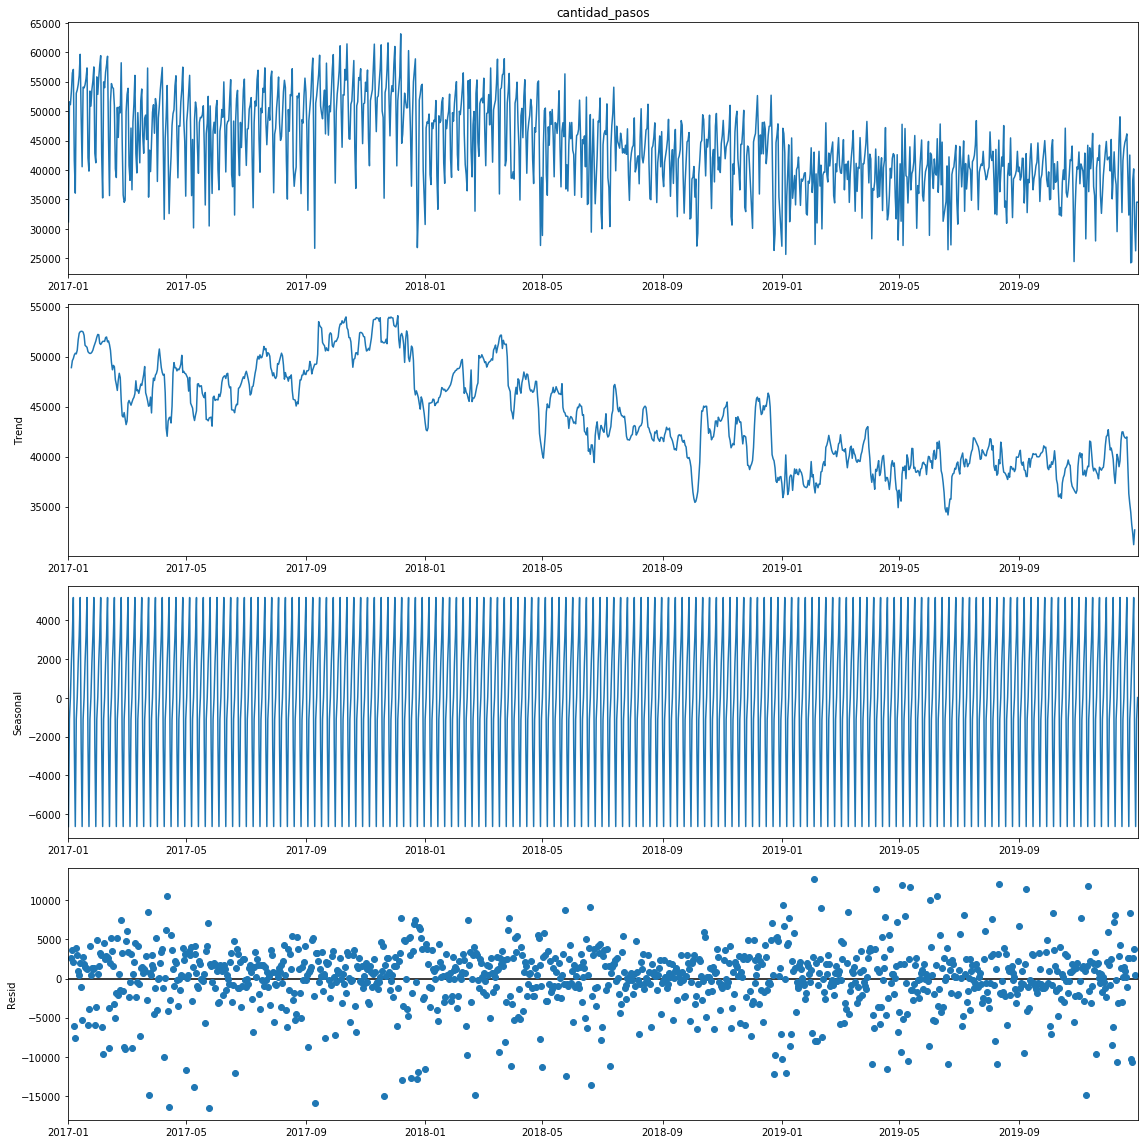

In [68]:
plt.rcParams["figure.figsize"] = (16, 16)
result.plot()
plt.show()

**Conclusiones componentes de la serie**

1. Vemos que la serie no estacionaria en la media, ya que tiene una tendencia decreciente, esto se puede deber a la forma de pago en efectivo decrece con los años porque se tiende a usar telepase, pero también la cantidad de pasos en general decrece couando observamos los tres dataset por separado, por lo que podemos atribuir ambas razones a la tendencia de la serie. 

    También por lo visto en puntos anteriores se puede decir que la serie tiene estacionalidad horaria, ya que según lo expresado anteriormente el mayor flujo d etráfico es entre las 17 y las 19, también tiene estacionalidad diaria o semanal ya que es mayor el tráfico en los días laborables y decae los fines de semana, también en ciertos meses como ser en Febrero baja mucho y luego sube, la media esta alrededor de los 45000, la desviación cerca de los 8000. 
    

2. La serie posee valores atipicos, en ciertos casos hay días donde no hay pasos o muy pocos, por ejemplo el 29/05/2019, 25/06/218, 25/09/2018, se levantaron las barreras por un paro general contra el gobierno, o el 30/11/2018 donde hubo cortes de calles y autopistas previos a la cumbre del G-20 en Buenos Aires, en otros casos donde los pasos son muy elevados corresponden a fechas como fin de año el 31-12 o 19-01-2019 que es Domingo y recambio turistico de las primer quincena del año.

### 2. Predicciones

A partir del dataset resampleado por días creamos un nuevo dataset

In [69]:
diario.shape

(1095, 1)

In [70]:
pasos = diario.cantidad_pasos
pasos.tail()

fecha
2019-12-27    40182.0
2019-12-28    30681.0
2019-12-29    26259.0
2019-12-30    34523.0
2019-12-31    34523.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [71]:
pasos.shape

(1095,)

***One Step Prediction***

Definimos cuantos valores hacia atrás tomamos para predecir, en este caso elegimos 7 días (una semana) teniendo en cuenta que son 3 meses solamente, probando con mas variables no mejora mucho las predicciónes y hace que el modelo sea mas complejo, por ejemplo se probó con 3 meses o un año y se llega a valores muy parecidos de error

In [72]:
look_back = 7

Creamos los X e y con ceros para luego llenar con los datos

In [73]:
N = pasos.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1087, 7) (1087,)


Llenamos los X e y

In [74]:
for i in range(X.shape[0]):
    X[i,:] = pasos.iloc[i:i+look_back]
    y[i] = pasos.iloc[i+look_back]

In [75]:
print(X)

[[31183. 51568. 51093. ... 56486. 57081. 41587.]
 [51568. 51093. 53332. ... 57081. 41587. 36065.]
 [51093. 53332. 56486. ... 41587. 36065. 53036.]
 ...
 [39303. 32337. 42531. ... 24349. 38168. 40182.]
 [32337. 42531. 24220. ... 38168. 40182. 30681.]
 [42531. 24220. 24349. ... 40182. 30681. 26259.]]


In [76]:
print(y)

[36065. 53036. 53601. ... 30681. 26259. 34523.]


Hago el train test split de los datos

In [77]:
N_train = (365*2) + (364-92) - look_back # usamos 1 año y 9 meses del segundo para entrenar. 
#print(N_train)
N_test = 92 #cantidad de puntos que vamos a usar para evaluar
#print(N_test)
N_total = N_train + N_test
print(N_total)

length_total = N_train + N_test + look_back
#print(length_total)

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

1087
(995, 7) (995,)
(92, 7) (92,)


Entrenamos un Random Forest

In [78]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1).fit(X_train,y_train)

Importancia de cada variable

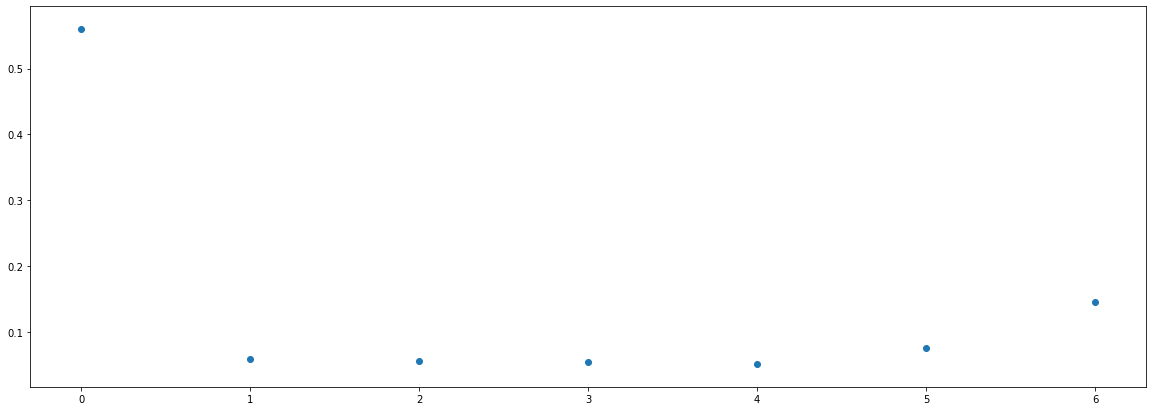

In [79]:
plt.figure(figsize = (20,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
plt.show()

In [80]:
rf.feature_importances_

array([0.5604169 , 0.05788718, 0.05529364, 0.05427805, 0.05051147,
       0.07575848, 0.14585428])

Predecimos

In [81]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

Graficamos

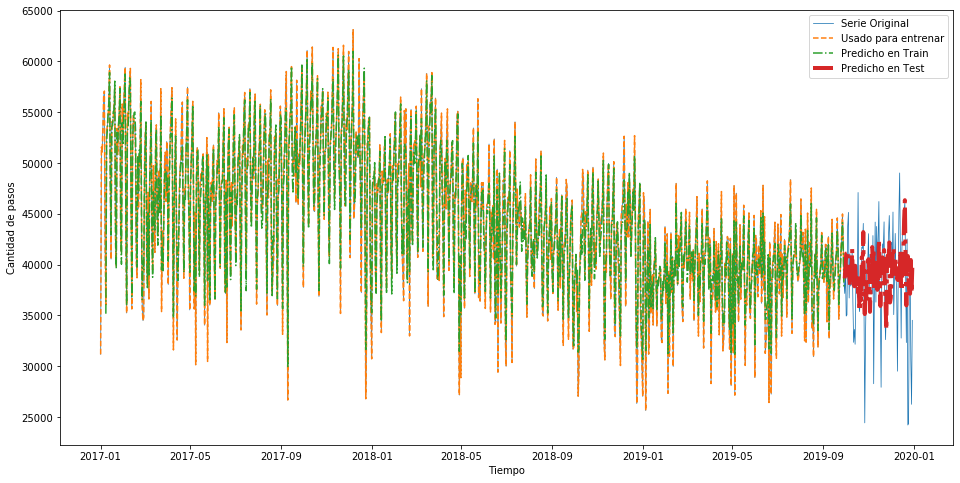

In [82]:
plt.figure(figsize=(16,8))
plt.plot(pasos.index[:length_total], pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(pasos.index[:N_train + look_back], pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(pasos.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

Calculamos el error en train y test

In [83]:
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

RMSE en Train: 1783.138730451316
RMSE en Test: 4908.520017749286


Defino una función para clacular el mean absolute percentage error (MAPE)

In [84]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [85]:
print('MAPE en train: ',mape(y_train, y_train_pred))
print('MAPE en test: ',mape(y_test, y_test_pred))

MAPE en train:  3.1567547955015827
MAPE en test:  10.270019495252383


***Benchmark***

Utilizando el conjunto de train y test generado para el modelo Random Forest calculamos un modelo Benchmark donde cada día se predice teniendo en cuenta el día anterior, de esta manera comprobamos si la primer predicción podemos tomarla como válida.

In [86]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

Graficamos la serie original contra lo predicho

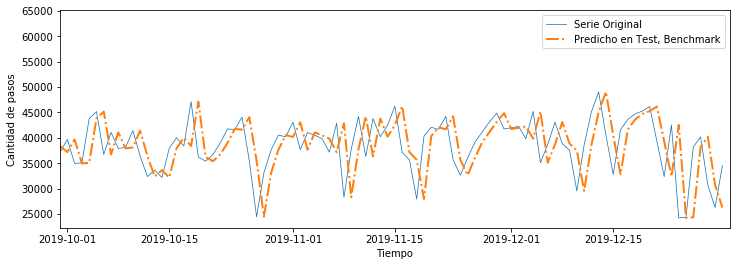

In [87]:
plt.figure(figsize=(12,4))
plt.plot(pasos.index[:length_total], pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(pasos.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(pasos.index[N_train+look_back], pasos.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

Calculamos el error del modelo de Benchmark

In [88]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print(np.sqrt(MSE))

6034.584014066429


Comparando el error con el del modelo Random Forest podemos afirmar que este último es mejor que el de Benchmark

***Multi Step Prediction: usamos el modelo entrenado en el punto anterior para hacer una predicción recursiva***

In [89]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

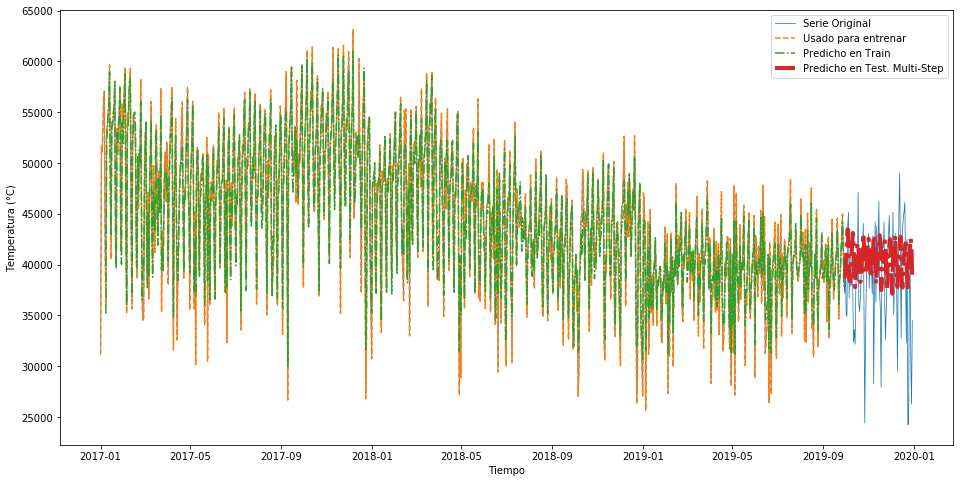

In [90]:
plt.figure(figsize=(16,8))
plt.plot(pasos.index[:length_total], pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(pasos.index[:N_train + look_back], pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(pasos.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.show()

In [91]:
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Test: 5485.7153208805275


In [92]:
print('MAPE en test: ',mape(y_test, y_ms_test_pred))

MAPE en test:  12.759554235799808


***Usamos Random Search para optimizar el modelos de Random Forest***

In [93]:
random_grid = {'n_estimators': np.arange(100,200),
               'max_features': ['auto', 'sqrt'],
               'max_depth': np.arange(1,10),
               'min_samples_split': [1, 2, 3,4]}

In [94]:
rf_random=RandomizedSearchCV(rf, param_distributions = random_grid, random_state=42, n_jobs = -1)

In [95]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                

In [96]:
print("Mejores parametros: "+str(rf_random.best_params_))
print("Mejor Score: "+str(rf_random.best_score_)+'\n')

scores = pd.DataFrame(rf_random.cv_results_)
scores

Mejores parametros: {'n_estimators': 165, 'min_samples_split': 3, 'max_features': 'sqrt', 'max_depth': 8}
Mejor Score: 0.3226830405269849



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.402520,0.053651,0.000000,0.000000,160,1,auto,2,"{'n_estimators': 160, 'min_samples_split': 1, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
1,0.844932,0.078778,0.129453,0.019901,190,2,sqrt,7,"{'n_estimators': 190, 'min_samples_split': 2, ...",0.495615,0.530813,0.430662,0.260570,-0.115120,0.320508,0.236808,2
2,0.487691,0.133509,0.000000,0.000000,126,1,sqrt,7,"{'n_estimators': 126, 'min_samples_split': 1, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
3,1.038014,0.154388,0.111102,0.001197,191,4,auto,7,"{'n_estimators': 191, 'min_samples_split': 4, ...",0.474352,0.497617,0.383064,0.258998,-0.203267,0.282153,0.256794,6
4,1.145925,0.138282,0.120876,0.007553,172,2,sqrt,5,"{'n_estimators': 172, 'min_samples_split': 2, ...",0.472900,0.520672,0.407879,0.235195,-0.120425,0.303244,0.232866,4
5,1.066937,0.048652,0.149997,0.035940,192,3,sqrt,4,"{'n_estimators': 192, 'min_samples_split': 3, ...",0.457302,0.493324,0.395930,0.206119,-0.146868,0.281161,0.235818,7
6,0.941474,0.107042,0.132843,0.011791,134,2,auto,8,"{'n_estimators': 134, 'min_samples_split': 2, ...",0.468928,0.502274,0.378536,0.260898,-0.189655,0.284196,0.251261,5
7,1.018068,0.058298,0.116290,0.011346,165,3,sqrt,8,"{'n_estimators': 165, 'min_samples_split': 3, ...",0.503414,0.534158,0.440049,0.262688,-0.126893,0.322683,0.243671,1
8,0.480311,0.098800,0.000000,0.000000,166,1,sqrt,1,"{'n_estimators': 166, 'min_samples_split': 1, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
9,0.655840,0.016731,0.105318,0.000489,134,2,sqrt,7,"{'n_estimators': 134, 'min_samples_split': 2, ...",0.496950,0.522874,0.425426,0.259441,-0.115522,0.317834,0.235333,3


Vovemos a predecir con los mejores parámetros encontrados

In [97]:
rf_opt = RandomForestRegressor(n_estimators=165, min_samples_split=3,max_features= 'sqrt',max_depth=8,random_state=42, n_jobs = -1).fit(X_train,y_train)

In [98]:
y_pred = rf_opt.predict(X)
y_train_pred = rf_opt.predict(X_train)
y_test_pred = rf_opt.predict(X_test)

Repetimos los pasos anterior, graficamos la serie y calculamos el error en train y test y el MAPE

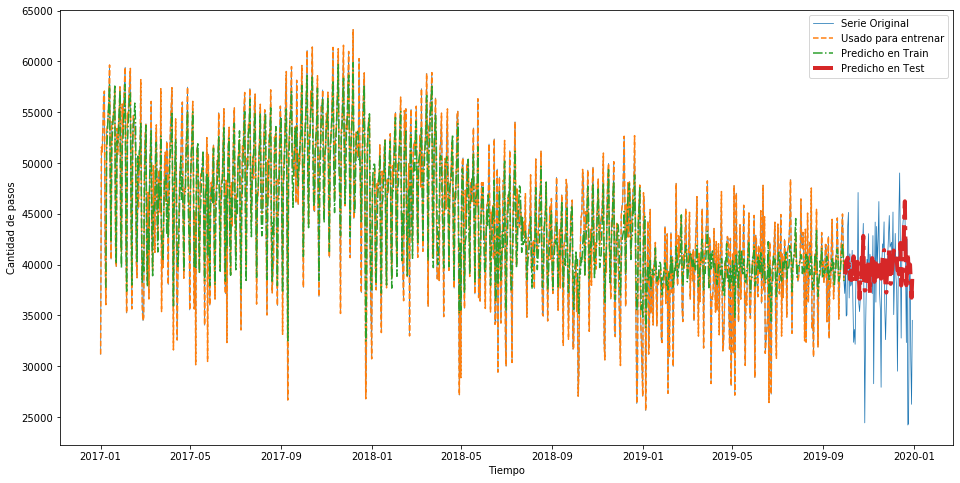

In [99]:
plt.figure(figsize=(16,8))
plt.plot(pasos.index[:length_total], pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(pasos.index[:N_train + look_back], pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(pasos.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

In [100]:
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

RMSE en Train: 3104.2364800314404
RMSE en Test: 4923.396685575291


In [101]:
print('MAPE en train: ',mape(y_train, y_train_pred))
print('MAPE en test: ',mape(y_test, y_test_pred))

MAPE en train:  5.749761724483987
MAPE en test:  10.613869148615251


Como conclusión podemos decir que si bien el error en test es apenas mas grande que el calculado anteriormente con One Step, la diferencia del error en train y test es menor.

***Predicción para 2020***

Traemos los datos del dataset del año 2020 para predecir de la misma manera que se hizo con el último trimestre del 2019

In [102]:
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')

In [103]:
data_2020

,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Centro,24
1,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80
2,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1
3,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1
4,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628076,2020,2020-08-31,agosto,Lunes,31,23,0,PB1,Pesados 6 Ejes,Tag,Tag - PosPago,Provincia,17
1628077,2020,2020-08-31,agosto,Lunes,31,23,0,PB1,Pesados 6 Ejes,Violación,Violación - Normal,Provincia,2
1628078,2020,2020-08-31,agosto,Lunes,31,23,0,PB4,Pesados 6 Ejes,Tag,Tag - PosPago,Centro,24
1628079,2020,2020-08-31,agosto,Lunes,31,23,0,PB4,Pesados 6 Ejes,Tag,Tag - PosPago OCR,Centro,1


Buscamos como figura la Autopista Illia y el tipo de pago Efectivo

In [104]:
print(data_2020['estacion'].unique())

['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']


In [105]:
print(data_2020['forma_pago'].unique())

['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP']


In [106]:
data_2020.groupby(['forma_pago']).sum().sort_values (by=['cantidad_pasos'] ,ascending=False) ['cantidad_pasos']

forma_pago
Tag                  26005117
Efectivo             16467350
Violación             9164245
CPP                    841379
Exento                 522600
Rec.Deuda              467246
Tarjeta Magnética      187256
Name: cantidad_pasos, dtype: int64

In [107]:
mask_2020 = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask_2020]

Agregamos la columna de fecha tal como hicimos con los dataset unificados de 2017/18/19

In [108]:
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

data_2020.head()

,periodo,mes,dia,dia_fecha,hora_inicio,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos,fecha2
52,2020,enero,Miércoles,1,0,ILLIA,Auto,Efectivo,Efectivo,Centro,326,2020-01-01 01:00:00
53,2020,enero,Miércoles,1,0,ILLIA,Auto,Efectivo,Efectivo,Provincia,319,2020-01-01 01:00:00
134,2020,enero,Miércoles,1,1,ILLIA,Auto,Efectivo,Efectivo,Centro,199,2020-01-01 02:00:00
135,2020,enero,Miércoles,1,1,ILLIA,Auto,Efectivo,Efectivo,Provincia,180,2020-01-01 02:00:00
202,2020,enero,Miércoles,1,2,ILLIA,Auto,Efectivo,Efectivo,Centro,114,2020-01-01 03:00:00


In [109]:
#Cambiamos el nombre de fecha2 a fecha
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 
data_2020.head()

,periodo,mes,dia,dia_fecha,hora_inicio,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos,fecha
52,2020,enero,Miércoles,1,0,ILLIA,Auto,Efectivo,Efectivo,Centro,326,2020-01-01 01:00:00
53,2020,enero,Miércoles,1,0,ILLIA,Auto,Efectivo,Efectivo,Provincia,319,2020-01-01 01:00:00
134,2020,enero,Miércoles,1,1,ILLIA,Auto,Efectivo,Efectivo,Centro,199,2020-01-01 02:00:00
135,2020,enero,Miércoles,1,1,ILLIA,Auto,Efectivo,Efectivo,Provincia,180,2020-01-01 02:00:00
202,2020,enero,Miércoles,1,2,ILLIA,Auto,Efectivo,Efectivo,Centro,114,2020-01-01 03:00:00


Resampleamos la serie a dias

In [110]:
diario_2020 = data_2020.resample('D', on = 'fecha').sum()
diario_2020.drop(columns = ['periodo','hora_inicio','dia_fecha'], inplace = True)
print(diario_2020.shape)
diario_2020.head()

(244, 1)


,cantidad_pasos
fecha,
2020-01-01,21395
2020-01-02,33722
2020-01-03,37067
2020-01-04,30627
2020-01-05,27812


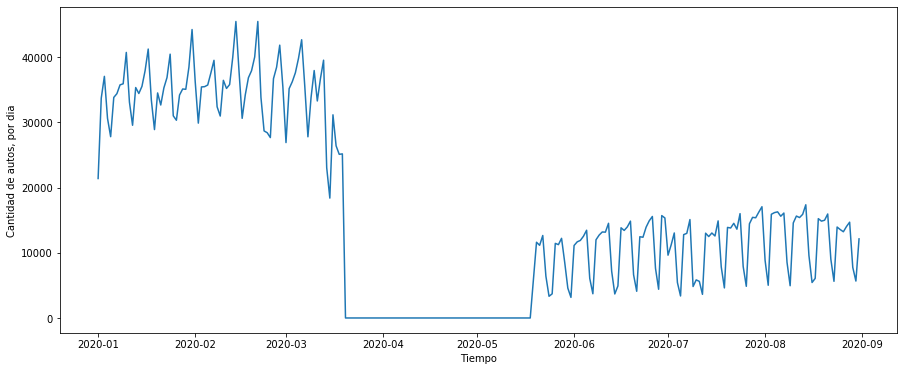

In [111]:
plt.figure(figsize = (15,6))
plt.plot(diario_2020.index, diario_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Concateno el dateset de 3 años con el generado del año 2020

In [112]:
pasos_2020 = diario_2020.cantidad_pasos

In [113]:
pasos_ext=pd.concat([pasos, pasos_2020])
pasos_ext

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
               ...   
2020-08-27    14034.0
2020-08-28    14696.0
2020-08-29     7767.0
2020-08-30     5663.0
2020-08-31    12133.0
Freq: D, Name: cantidad_pasos, Length: 1339, dtype: float64

Predecimos repitiendo los pasos para One Step

Definimos cuantos valores hacia atrás tomamos para predecir, en este caso 7 días como tomamos anteriormente no nos va a servir porque son pocas variables para predecir un año, vamos a usar un look_back de 365

In [114]:
look_back = 365

Creamos los X e y con ceros para luego llenar con los datos

In [115]:
N = pasos_ext.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(973, 365) (973,)


Llenamos los X e y

In [116]:
for i in range(X.shape[0]):
    X[i,:] = pasos_ext.iloc[i:i+look_back]
    y[i] = pasos_ext.iloc[i+look_back]

Hacemos el train test split de los datos

In [117]:
N_train = (365*2) + (364) - look_back # usamos 2 años para entrenar. 
print(N_train)
N_test = 244 #cantidad de puntos que vamos a usar para evaluar
#print(N_test)
N_total = N_train + N_test
print(N_total)

length_total = N_train + N_test + look_back
#print(length_total)

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

729
973
(729, 365) (729,)
(244, 365) (244,)


Entrenamos un Random Forest

In [118]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1).fit(X_train,y_train)

Predecimos

In [119]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

Graficamos

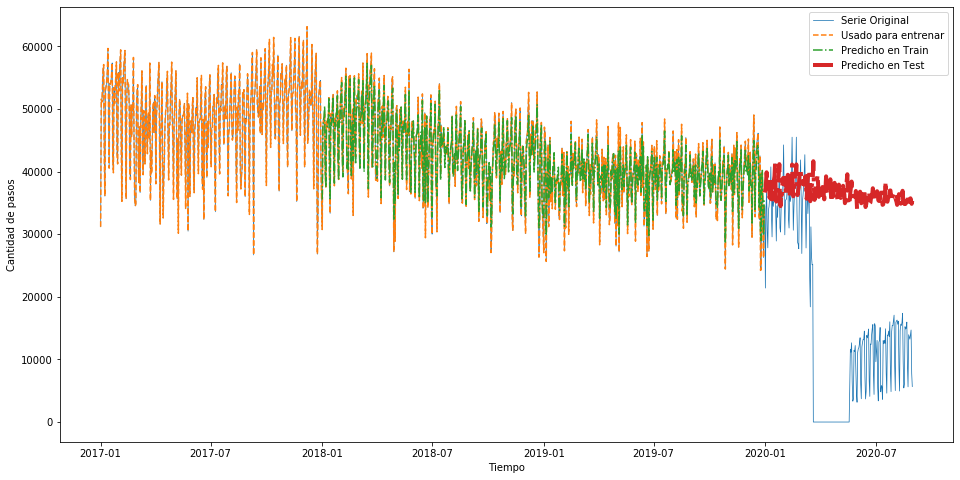

In [120]:
plt.figure(figsize=(16,8))
plt.plot(pasos_ext.index[:length_total], pasos_ext[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(pasos_ext.index[:N_train + look_back], pasos_ext[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(pasos_ext.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(pasos_ext.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

Como ya sabemos el 2020 es un año atipico por la pandemia por lo que es imposible predecir con datos de años anteriores, por este motivo vamos a calcular el error en test tomando solamente los días hasta que empezó la cuarentena.

Calculamos los errores RMSE y MAPE

In [121]:
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))
MSE = mean_squared_error(y_test[:78], y_test_pred[:78])
print('RMSE en Test:',np.sqrt(MSE))
print('MAPE en train: ',mape(y_train, y_train_pred))
print('MAPE en test: ',mape(y_test[:78], y_test_pred[:78]))

RMSE en Train: 1656.7901150211462
RMSE en Test: 5340.893707851312
MAPE en train:  3.1737381556911846
MAPE en test:  13.29837387550697


**Conclusiones predicciones y explicación de los puntos desarrollados**

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.

    En este punto resampleamos el dataset a días, semanas, meses para analizarlos por separado y luego para predecir tomando el dataset resampleado por días.

2. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.

    Evaluamos los modelos con rmse para comparar como se comportan en Train y Test y para medir la desviación de los errores, para Random el comportamiento no es bueno ya que hay mucha diferencia entre Train y Test, es como si el modelo aprende muy bien el comportamiento de la serie cuando entrena, y luego no logra replicarlo en test, en este caso vemos que se comporta mejor con One Step que con Multi Step, luego con la optimización podemos concluir que si bien el error en test es apenas mas grande que el calculado anteriormente con One Step, la diferencia del error en train y test es menor.
    
    En cuanto al modelo de Benchmark usamos también rmse para compararlo con las predicciones del Random Forest, en este caso es algo menor en este último por lo cual se pueden aceptar las primeras predicciones comparadas contra el modelo básico.
    
    Debido a que Rmse depende de la unidad, y es relativo decidir que tan bueno puede ser un error de 5000 por ejemplo, también usamos Mean absolute percentage error (MAPE), de esta manera llegamos a un error optimizado de alrededor del 10%.

3. Elige un modelo benchmark y compara tus resultados con este modelo.

    Según lo expresado en el punto anterior todos los medelos generados tienen mejor valor en rmse que el que surge del Benchmark

4. Optimiza los hiperparámetros de tu modelo.

    En este punto usamos Random Search para optimizar los hiperparámetros del modelo Random Forest, si bien el MAPE es apenas mayor que el que se obtiene en el primer modeledo corriendo los datos con One Step, la diferencia entre train y test tanto para RMSE como para MAPE se achica, por cual podemos suponer que el modelo optimizado va a funcionar mejor para futuras predicciones.

5. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

    En este punto graficamos las variables mas importantes del modelo Random Forest, se puede observar que el primer y el último día son los que toman preponderancia por sobre el resto, en este punto teniendo en cuenta que cada semana tiene un comportamiento marcado con días pico de tráfico y días con poco tráfico, me esperaba que el modelo priorice los días con mas trpafico por sobre el resto.

6. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?

    Como se puede observar en las gráficas realizadas la seria resampleada a días del año 2020 difiere mucho en cantidad de pasos con la serie de los años 2107, 2018 y 2019, ya que por el inicio de la cuarentena no hubo peaje desde mediados de Marzo hasta Abril y Mayo, y luego a pesar de las apertura el tráfico no volvió a ser normal ya que la cuarentena se fue flexibilizando de a poco.

### Para pensar, investigar y, opcionalmente, implementar

1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?

    Para incorporar información sobre tipo de vehículo, forma de pago, sentido, día de la semana y demás features haría un encoding para llevar todo a un formato numérico, la fecha la dividiría para incorporar features de día, mes y año, luego usaría algún modelo como XG Boost o Random Forest. En cuanto a las predicciones teniendo en cuenta que estamos prediciendo sobre series de tiempo entiendo que las mismas no deberían ser tan óptimas, ya que existen modelos específicos para pronosticar sobre Seies de Tiempo, como ser dividir los datos con One Step o Multi Step y luego aplicar un modelo, o bien librerías como Prophet o modelos específicos como ser Arima o Sarima.

2. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?

Armamos un nuevo dataset con los datos de 2017, 2018 y 2019 

In [122]:
data_est = pd.concat([data_2019, data_2018, data_2017])
data_est.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [123]:
print(data_est['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB' 'Alberdi' 'Dellepiane Centro' 'Dellepiane Liniers']


Tal como hicimos anteriormente vamos a agregar una columna de fecha para luego resamplear la serie

In [124]:
data_est['fecha2'] = pd.to_datetime(data_est.fecha) + pd.to_timedelta(data_est.hora_fin, unit = 'h')
data_est.drop(columns=['fecha','hora_fin'], inplace = True)
data_est.rename(columns = {'fecha2':'fecha'}, inplace = True) 
data_est.sort_values('fecha', inplace = True)
data_est.reset_index(drop=True, inplace = True)

In [125]:
data_est.head()

,periodo,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,2017,23,Domingo,Dellepiane Centro,Centro,Liviano,NO COBRADO,6,2017-01-01
1,2017,23,Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01
2,2017,23,Domingo,Illia,Provincia,Liviano,NO COBRADO,3,2017-01-01
3,2017,23,Domingo,Dellepiane Liniers,Provincia,Liviano,INFRACCION,3,2017-01-01
4,2017,23,Domingo,Avellaneda,Centro,Liviano,NO COBRADO,36,2017-01-01


Renombramos Dellepiane Liniers y Centro ya que en 2019 se unifican con Dellepiane

In [126]:
data_est.estacion[data_est.estacion =='Dellepiane Centro'] ='Dellepiane'
data_est.estacion[data_est.estacion =='Dellepiane Liniers'] ='Dellepiane'
data_est.head()

,periodo,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,2017,23,Domingo,Dellepiane,Centro,Liviano,NO COBRADO,6,2017-01-01
1,2017,23,Domingo,Illia,Provincia,Liviano,EFECTIVO,9,2017-01-01
2,2017,23,Domingo,Illia,Provincia,Liviano,NO COBRADO,3,2017-01-01
3,2017,23,Domingo,Dellepiane,Provincia,Liviano,INFRACCION,3,2017-01-01
4,2017,23,Domingo,Avellaneda,Centro,Liviano,NO COBRADO,36,2017-01-01


Unificamos Alberti y Alberdi

In [127]:
data_est.estacion[data_est.estacion =='Alberti'] ='Alberdi'

Por cada una de las estaciones resampleamos a mes para luego graficar la serie

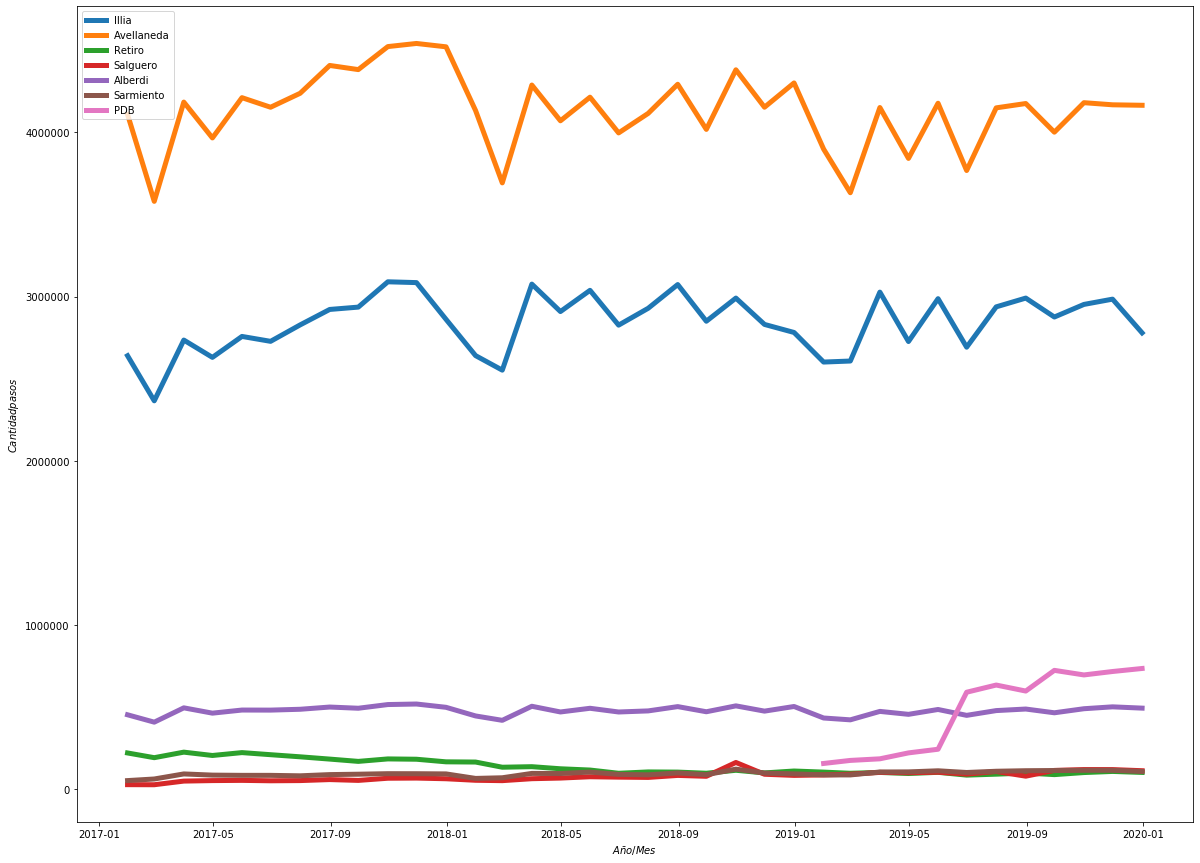

In [128]:
estacion = data_est['estacion'].unique()

plt.figure(figsize = (20,15))
plt.gca().set(ylabel='$Cantidad pasos$', xlabel='$Año/Mes$')

for i, y in enumerate(estacion):
    if i > 0:        
        mensual = data_est[data_est.estacion==y].resample('M', on = 'fecha').sum()
        plt.plot(mensual.index, mensual.cantidad_pasos,lw = 0.75, label = y,linewidth=5)
        plt.legend(loc="upper left")     

Volvemos a graficar pero ahora tomamos un límite de y mas chico para ver mejor el comportamiento de las estaciones que tienen menos tráfico

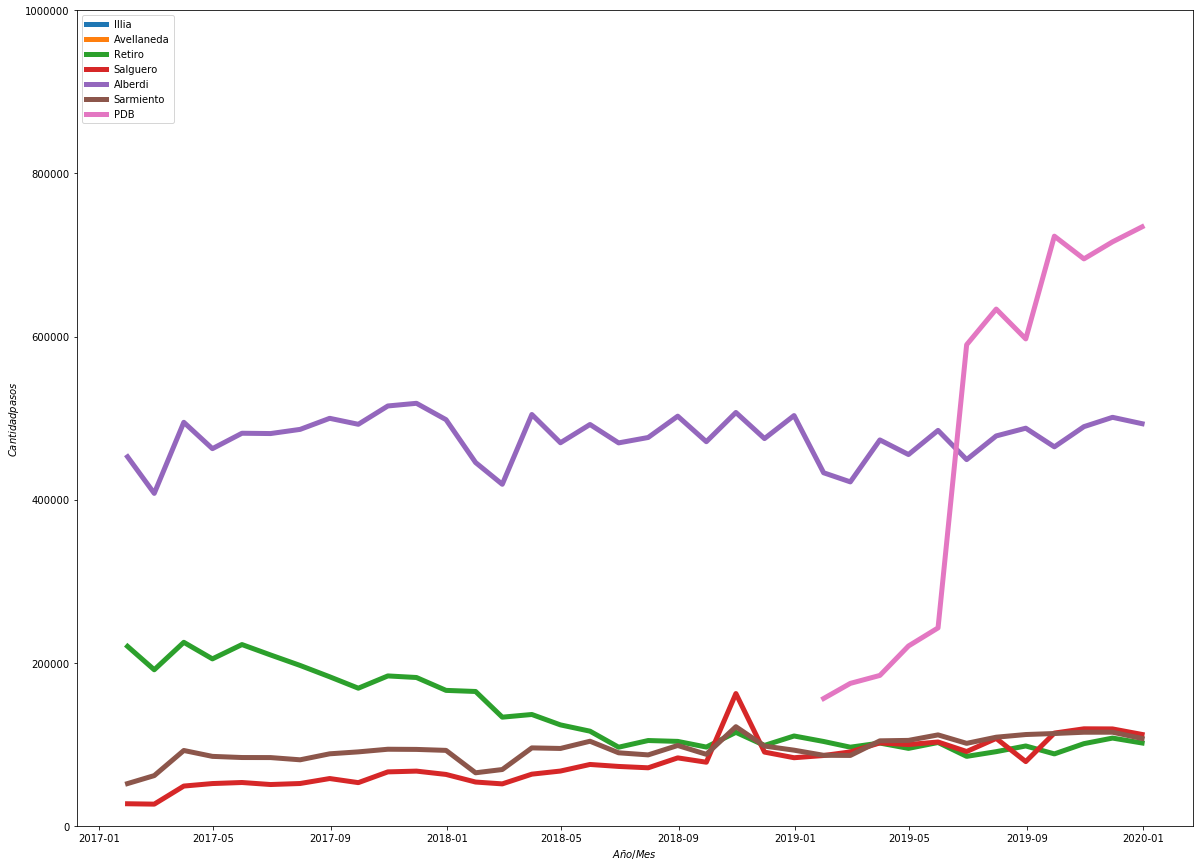

In [129]:
estacion = data_est['estacion'].unique()

plt.figure(figsize = (20,15))
plt.gca().set(ylabel='$Cantidad pasos$', xlabel='$Año/Mes$')
plt.ylim(0,1000000)

for i, y in enumerate(estacion):
    if i > 0:        
        mensual = data_est[data_est.estacion==y].resample('M', on = 'fecha').sum()
        plt.plot(mensual.index, mensual.cantidad_pasos,lw = 0.75, label = y,linewidth=5)
        plt.legend(loc="upper left")   

Analizando la distribución de los pasos por meses vemos que Avellaneda e Illia tienen un comportamiento muy parecido incluso son las dos que mas cantidad de pasos tienen, la que difiere un poco del resto es Retiro que tiene una tendencia decreciente mas marcada, con los años se van realizando obras que tratan de aliviar el tráfico por ciertas autopiestas que hay mucha congestión, nuevas trazas, carriles rápidos etc lo que ayuda a desviar el tráfico por vías alternativas, otro caso es PDB (Paseo del bajo), un tramo nuevo que se extiende desde la autopista Buenos Aires - La Plata hasta la autopista Illia, la cantidad de pasos va en constante crecimiento al ser una vía rápida que agiliza mucho el tráfico.

3. ¿Hay algo que te gustaría investigar o probar?

Este proyecto lo encaré puntualemente con lo visto en clase y basandome en la consigna que dice aplicar las técnicas de Machine Learning aprendidas, por eso como pendiente considero que me quedaría investigar/implementar algun modelo para series de tiempo como ser Prophet o Arima, la justificación es que son específicos para trabajar con series de tiempo, para implementarlo lo haría siguiendo los pasos de la documentación que encotré al repecto, dejo un ejemplo de cada uno (Arima: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b - Prophet: https://www.kdnuggets.com/2018/11/sales-forecasting-using-prophet.html). Una vez implementado espero obtener una mejora en las predicciones justamente por lo expresado anteriormente, son modelos específicos para trabajar con series de tiempo.

También otra punto a probar sería incorporar la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, y ver si realmente mejora o no el modelo y validar o no lo expuesto en el punto 1 de este apartado.